# Unsupervised learning: Mixture of Gaussians

In this assignment, your tasks will be: (i) to generate some data from a mixture of Gaussians (MoG) model, and (ii) subsequently fit a MoG model to this data, in order to recover the original parameters.

- <a href='#question 1'>Question 1</a> This part has been done for you. You only have to read the code in `mixGaussGen` to understand how we generate data from our Mixture of Gaussians model.
- <a href='#question 2'>Question 2</a> Fill in the missing code for function `mixGaussPDF`
- <a href='#question 3'>Question 3</a> Fill in the missing code for function `getMixGaussLogLike`
- <a href='#question 4'>Question 4</a> Fill in the missing code in the EM algorithm.
- <a href='#question 5'>Question 5</a> Fit mixture of Gaussians to data for classification.
    - <a href='#question 5a'>Question 5a</a> Fit MoG to positive class.
    - <a href='#question 5b'>Question 5b</a> Fit MoG to negative class.
- <a href='#question 6'>Question 6</a> Calculate the posterior for the positive class using Bayes' rule and compare it to the actual posterior.

  
    

## Imports

In [1]:
%load_ext autoreload
%autoreload 2

import sys
import time

import matplotlib.pyplot as plt
import numpy as np
from IPython import display
from scipy.stats import multivariate_normal

from construct_data_mod import construct_data, drawGaussianOutline

flt_min = sys.float_info.min

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0)  # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

### Define parameters for a mixture of k Gaussians (MoG)

Here we are going to define the true parameters for a mixture of $K=3$ Gaussians.
We are representing the mixture of Gaussians as a numpy dictionary. 
In $d$ dimensions, the 'mean' field is a $d\times K$ matrix and the 'cov' field is a $d\times d \times K$ matrix. The 'weight' field is a list of weights $\pi_i$ of the mixture component $i$.

In [2]:
mixGaussTrue = dict()
mixGaussTrue['K'] = 3
mixGaussTrue['d'] = 2
mixGaussTrue['weight'] = np.array([0.1309, 0.3966, 0.4725])
mixGaussTrue['mean'] = np.array([[4.0491, 4.8597],
                                 [7.7578, 1.6335],
                                 [11.9945, 8.9206]]).T
mixGaussTrue['cov'] = np.zeros(shape=(mixGaussTrue['d'], mixGaussTrue['d'], mixGaussTrue['K']))
mixGaussTrue['cov'][:,:,0] = np.array([[4.2534, 0.4791],
                                       [0.4791, 0.3522]])
mixGaussTrue['cov'][:,:,1] = np.array([[0.9729, 0.8723],
                                       [0.8723, 2.6317]])
mixGaussTrue['cov'][:,:,2] = np.array([[0.9886, -1.2244],
                                       [-1.2244, 3.0187]])

<a id='question 1'></a>
# Generate data from MoG

Function `mixGaussGen` generates data by randomly sampling a mixture of Gaussians. In order to sample the data:
1. We need to pick one of $K$ components by sampling the discrete distribution formed by the MoG's weights.
2. Using the mean and covariance corresponding to the selected component, we sample a new point from a multivariate Gaussian distribution.

<b>Question 1:</b> Fill in the missing code in function `mixGaussGen`. Hint: numpy provides `np.random.choice` to randomly select a value given some weights (the 'p' parameter), and `np.random.multivariate_normal` to randomly sample a multivariate Gaussian distribution.

In [3]:
# define number of samples to generate
nData = 400

# this function generates data from a k-dimensional                                           
# mixture of Gaussians structure.                                          
def mixGaussGen(mixGauss, nData):                                                                              
    np.random.seed(123)
    
    ############ TO DO QUESTION 1 #################
    # create space for output data
    data = np.zeros(shape=(mixGauss['d'], nData))                                                                            
    # for each data point                                                                                        
    for cData in range(nData):                                                                                   
        # randomly choose Gaussian according to probability distributions                                        
        h = np.random.choice(mixGauss['K'], p=mixGauss['weight'])
        # draw a sample from the appropriate Gaussian distribution  
        # using function np.random.multivariate_normal with the correct mean and covariance
        curMean = mixGauss['mean'][:,h]                                                                          
        curCov = mixGauss['cov'][:, :, h]  
        data[:, cData] = np.random.multivariate_normal(curMean, curCov)   
    
    ############ END - TO DO QUESTION 1 #################
    
    return data         

In [4]:
# this routine draws the generated data and plots the MoG model on top of it
def drawEMData2d(ax, data, mixGauss, title_text=""):
    ax.plot(data[0,:], data[1,:], 'k.')
    ax.set_title(title_text)
    for cGauss in range(mixGauss['K']):
        drawGaussianOutline(ax,
                            mixGauss['mean'][:,cGauss],
                            mixGauss['cov'][:,:,cGauss],
                            mixGauss['weight'][cGauss])    
    return

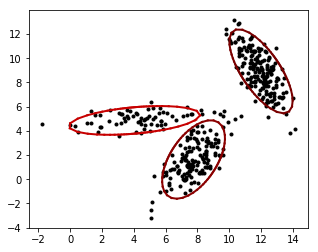

In [5]:
# generate data from the mixture of Gaussians
# TODO - fill in this routine (above)
data = mixGaussGen(mixGaussTrue,nData)

# draw data, true Gaussians
fig, ax = plt.subplots()
drawEMData2d(ax, data, mixGaussTrue)

<a id='question 2'></a>

# Calculate probability density of Mixture of gaussians

<b>Question 2:</b> Fill in the missing code for function `mixGaussPDF`. This function should give the result of the expression: $$p(\mathbf{x})=\sum_{k=1}^{K}\pi_k* N(\mathbf{x}\vert\mu_k,\Sigma_k)$$

It should be able to handle multiple datapoints at once. The input should have dimensions $2\times N$ and the output $1\times N$. Hint: use the function `multivariate_normal.pdf` from `scipy.stats` (imported in the first cell) to get the probability density of a multivariate normal distribution.

In [6]:
def mixGaussPDF(data, mixGaussEst):                                                             
    data = np.atleast_2d(data)                                                                         
    # find total number of data items                                                                  
    nDims, nData = data.shape 
    if nDims != mixGaussEst['d']:
        print('Error! Wrong number of dimensions for data!')
    
    K = mixGaussEst['K']
    weight = mixGaussEst['weight']
    mean = mixGaussEst['mean']
    cov = mixGaussEst['cov']
    
    ############ TO DO QUESTION 2 #################
    probDensity = sum(
        weight[k] * multivariate_normal.pdf(data.T, mean[:, k], cov[:, :, k])
        for k in range(K)
    )
    ############ END - TO DO QUESTION 2 #################
    return probDensity

<a id='question 3'></a>
# Calculate log likelihood of mixture of gaussians

<b>Question 3:</b> Fill in the missing code for function `getMixGaussLogLikelihood`. This function should return the log-likelihood of $\theta=(\{\mu_k\},\{\Sigma_k\},\{\pi_k\})$ given a set of points $\mathbf{x}$:
$$l(\theta; \mathbf{x}) = \sum_{i=1}^N \log(\sum_{k=1}^K \pi_k∗\mathcal{N}(\mathbf{x}^i|\mu_k,\Sigma_k))$$
 
The input should have dimensions $2×N$ and the output is a single number. Hint: call the function `mixGaussPDF` above to compute the argument of the log.

In [7]:
def getMixGaussLogLikelihood(data, mixGaussEst):                                                             
    data = np.atleast_2d(data)                                                                                                                                           
    ############ TO DO QUESTION 3 #################
    logLike = np.sum(np.log(mixGaussPDF(data, mixGaussEst)))
    ############ END - TO DO QUESTION 3 #################
        
    return np.asscalar(logLike)  

<a id='question 4'></a>
<a id='question 7'></a>
# Fit Mixture of Gaussians model to data 

This is the main part of our EM algorithm. Within this algorithm we iterate between the following two steps: 
* <b>Expectation Step:</b> in this step, we calculate a complete posterior distribution over each of the hidden variables (for each datapoint, we have a hidden variable assigning it to one of the mixtures)
* <b>Maximization Step:</b> in this step we update the parameters of the Gaussians (mean, cov, weight) using the posterior distributions calculated during the expectation step. 

The file "MoGCribSheet.pdf" is given to you to help you with this part of the assignment.  
<b>Question 4:</b> Fill in the missing code in the EM algorithm. Follow the instructions given in the comments as well as the forementioned pdf.

In [8]:
def fitMixGauss(data, K, nIter=20):
    nDims, nData = data.shape

    #     MAIN E-M ROUTINE
    #     there are nData data points, and there is a hidden variable associated
    #     with each.  If the hidden variable is 0 this indicates that the data was
    #     generated by the first Gaussian.  If the hidden variable is 1 then this
    #     indicates that the hidden variable was generated by the second Gaussian
    #     etc.

    postHidden = np.zeros(shape=(K, nData))

    #     in the E-M algorithm, we calculate a complete posterior distribution over each of
    #     the (nData) hidden variables in the E-Step.  In the M-Step, we
    #     update the parameters of the Gaussians (mean, cov, w).
    
    ############ TO DO - EXTRA QUESTION #################
    # initialize parameters
    mixGaussEst = dict()
    mixGaussEst['d'] = nDims
    mixGaussEst['K'] = K
    mixGaussEst['weight'] = np.full(shape=K, fill_value=1/K)
    # initialize means and covariances using data statistics
    mean_data = np.mean(data, axis=1).reshape(nDims, 1)
    mixGaussEst['mean'] = (1 + 0.1*np.random.normal(size=(nDims, K))) * mean_data
    mixGaussEst['cov'] = np.zeros(shape=(nDims, nDims, K))
    cov_data = np.cov(data)
    for k in range(K):
        mixGaussEst['cov'][:, :, k] = cov_data * (1 +  0.1*np.random.normal())
    ############ END - EXTRA QUESTION #################
        
    ############ TO DO QUESTION 4 #################
    # calculate current likelihood
    # TO DO - fill in this routine
    logLikelihoodsList = []
    logLikehood = getMixGaussLogLikelihood(data, mixGaussEst)
    #print('Log Likelihood Iter 0 : {:4.3f}\n'.format(logLike))
    logLikelihoodsList.append(logLikehood)

    fig, ax = plt.subplots(1, 1)

    for cIter in range(nIter):

        # ===================== =====================
        # Expectation step (4a)
        # ===================== =====================

        for i in range(nData):
            ############ TO DO QUESTION 4a #################
            # fill in column of 'hidden' - calculate posterior probability that
            # this data point came from each of the Gaussians
            # replace this:
            
            #<insert>
            #postHidden[:, cData] = 1/k
            #</insert>
            #<delete>
            xi = data[:, i]
            for k in range(mixGaussEst['K']):
                curWeight = mixGaussEst['weight'][k]
                curMean = mixGaussEst['mean'][:, k]
                curCov = mixGaussEst['cov'][:, :, k]
                postHidden[k, i] = curWeight * multivariate_normal.pdf(xi, curMean, curCov)
            postHidden[:, i] /= (np.sum(postHidden[:, i]) + flt_min)
            #</delete>
        

        # ===================== =====================
        # Maximization Step (4b)
        # ===================== =====================
        ############ TO DO QUESTION 4b #################
        
        # for each constituent Gaussian
        for k in range(K):
            # TO DO (4c) Update weighting parameters mixGauss.weight based on the total
            # posterior probability associated with each Gaussian. Replace this:
            
            #<insert>
            #mixGaussEst['weight'][k] = mixGaussEst['weight'][k]
            #</insert>
            #<delete>
            thisResp = postHidden[k]
            mixGaussEst['weight'][k] = np.sum(thisResp) / np.sum(postHidden)
            #</delete>
            
            # TO DO (4d):  Update mean parameters mixGauss.mean by weighted average
            # where weights are given by posterior probability associated with
            # Gaussian.  Replace this:
            
            #<insert>
            #mixGaussEst['mean'][:,k] = mixGaussEst['mean'][:,k]
            #</insert>
            #<delete>
            mixGaussEst['mean'][:, k] = data @ thisResp / np.sum(thisResp)
            #</delete>
            
            # TO DO (4e):  Update covariance parameter based on weighted average of
            # square distance from update mean, where weights are given by
            # posterior probability associated with Gaussian
            
            #<insert>
            #mixGaussEst['cov'][:,:,k] = mixGaussEst['cov'][:,:,k]
            #</insert>
            #<delete>
            tmp = data - mixGaussEst['mean'][:, k][:,None] # convert to 2D by adding extra dimension
            mixGaussEst['cov'][:, :, k] = (tmp @ np.diag(thisResp)) @ (tmp.T) / np.sum(thisResp)
            #</delete>
            
        ############ END - TO DO QUESTION 4 #################
        # draw the new solution
        title_text = "EM: Iteration {}".format(cIter)
        ax.clear()
        drawEMData2d(ax, data, mixGaussEst, title_text)
        display.display(fig)
        display.clear_output(wait=True)
        time.sleep(0.1)

        # calculate the log likelihood
        logLikehood = getMixGaussLogLikelihood(data, mixGaussEst)
        logLikelihoodsList.append(logLikehood)
    
    # Plot the likelihoods after each iteration
    fig, ax = plt.subplots()
    ax.plot(logLikelihoodsList)
    ax.set_xlabel('Iteration')
    ax.set_title('Log-Likelihood')

    return mixGaussEst

Now we use the completed function `fitMixGauss` to fit our data.

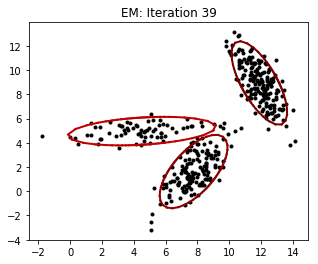

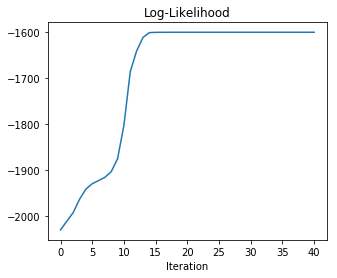

In [9]:
#define number of components to estimate
nGaussEst = 3

#fit mixture of Gaussians (Pretend someone handed you some data. Now what?)
#TO DO fill in this routine (above)
mixGaussEst = fitMixGauss(data, nGaussEst, nIter=40)

<a id='question 5'></a>
## Use mixture of Gaussians for classification

We will now use the dataset we used in previous assignments for classification. This dataset is actually generated using 2 mixtures of Gaussians with 3 and 4 components for the positive and negative classes respectively. 

<b>Question 5:</b> Use function `fitMixGauss` to get an estimate on the parameters of these two mixtures of gaussians. 

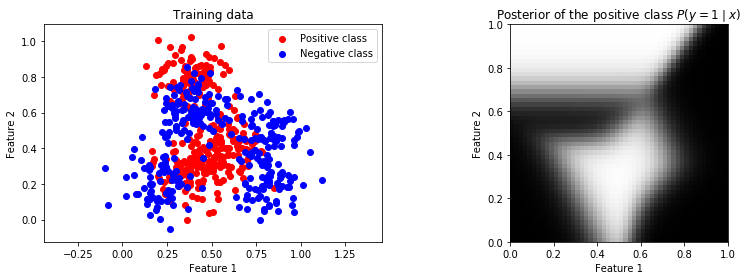

In [10]:
training_features, training_labels, posterior = construct_data(600, 'train', 'nonlinear' , plusminus=False)

# Extract features for both classes
features_pos = training_features[training_labels == 1].T
features_neg = training_features[training_labels != 1].T

# Display data
fig = plt.figure(figsize=plt.figaspect(0.3))
ax = fig.add_subplot(1, 2, 1)
ax.scatter(features_pos[0,:], features_pos[1,:], c="red", label="Positive class")
ax.scatter(features_neg[0,:], features_neg[1,:], c="blue", label="Negative class")
ax.axis('equal')
ax.set_title("Training data")
ax.set_xlabel("Feature 1")
ax.set_ylabel("Feature 2")
ax.legend()

ax = fig.add_subplot(1, 2, 2)
ax.imshow(posterior, extent=[0, 1, 0, 1], origin='lower')
ax.set_title("Posterior of the positive class $P(y=1 \mid x)$")
ax.set_xlabel("Feature 1")
ax.set_ylabel("Feature 2")
plt.show()

<a id='question 5a'></a>
## Fit mixture of Gaussians with 2 components to the positive class.

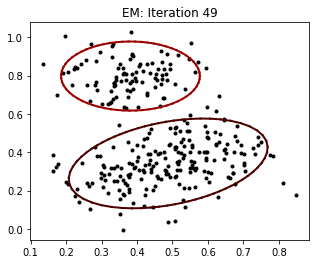

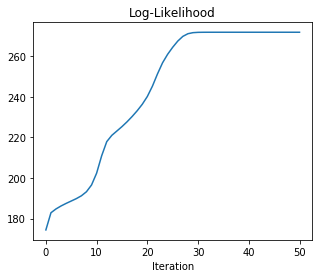

In [11]:
#define number of components to estimate
numGaussPositiveEst = 2

############ TO DO QUESTION 5a #################
# fill in the correct arguments
mixGaussPositiveEst = fitMixGauss(features_pos, numGaussPositiveEst, nIter=50)


<a id='question 5b'></a>
## Fit mixture of Gaussians with 2 components to the negative class.

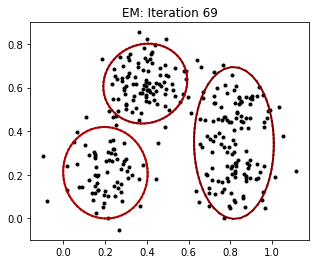

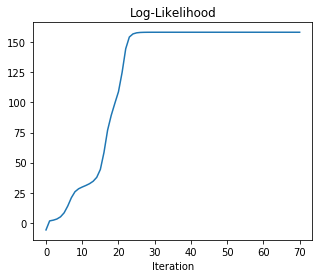

In [12]:
#define number of components to estimate
numGaussNegativeEst = 3

############ TO DO QUESTION 5b #################
# fill in the correct arguments
mixGaussNegativeEst = fitMixGauss(features_neg,numGaussNegativeEst, nIter=70)


<a id='question 6'></a>
## Calculate the posterior for the positive class.
For this part of the assignment you need to use: the two class conditional distributions for the positive and the negative class (the mixture of Gaussians you've just estimated), the priors for each class, and Bayes' rule to calculate the posterior distribution for the positive class. You are also going to use the function `mixGaussPDF` here.

<b>Question 6:</b> Calculate the posterior for the positive class using Bayes' rule and compare it to the actual posterior.

In [13]:
x_range = np.linspace(0, 1, 50)
y_range = np.linspace(0, 1, 50)
grid_x, grid_y = np.meshgrid(x_range, y_range)
xy_array = np.row_stack([grid_x.flat, grid_y.flat])

############ TO DO QUESTION 6 #################
# calculate class conditional probabilities for positive and negative class

pos_class_on_grid = mixGaussPDF(data=xy_array, mixGaussEst=mixGaussPositiveEst)
neg_class_on_grid = mixGaussPDF(data=xy_array, mixGaussEst=mixGaussNegativeEst)

# calculate prior probabilities for positive and negative class
prior_pos = 0.5
prior_neg = 0.5

# calculate posterior probabilities for positive class using Bayes' rule
posterior_positive = pos_class_on_grid * prior_pos / (pos_class_on_grid*prior_pos + neg_class_on_grid*prior_neg)

############ END - TO DO QUESTION 6 #################


# reshape posterior probability to plot it as an image
posterior_positive = posterior_positive.reshape(grid_x.shape)



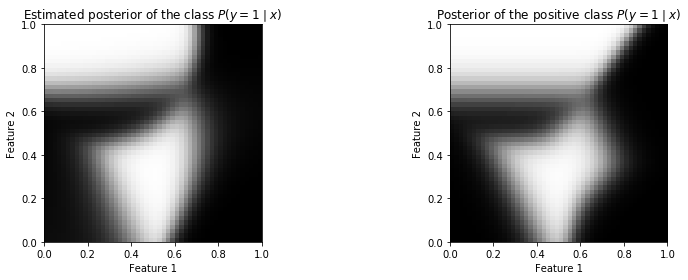

In [14]:
fig = plt.figure(figsize=plt.figaspect(0.3))
ax = fig.add_subplot(1, 2, 1)
ax.imshow(posterior_positive, extent=[0, 1, 0, 1], origin='lower')
ax.set_title("Estimated posterior of the class $P(y=1 \mid x)$")
ax.set_xlabel("Feature 1")
ax.set_ylabel("Feature 2")

ax = fig.add_subplot(1, 2, 2)
ax.imshow(posterior, extent=[0, 1, 0, 1], origin='lower')
ax.set_title("Posterior of the positive class $P(y=1 \mid x)$")
ax.set_xlabel("Feature 1")
ax.set_ylabel("Feature 2")
plt.show()